In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16
from tqdm import tqdm

plt.rcParams.update({
    "axes.titlesize": 14,    
    "axes.labelsize": fontsize,   
})


mse_fn = tf.keras.losses.MeanSquaredError()

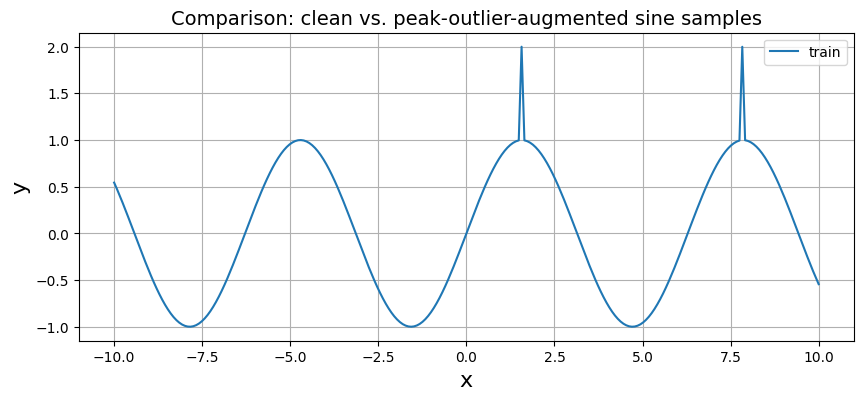

100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


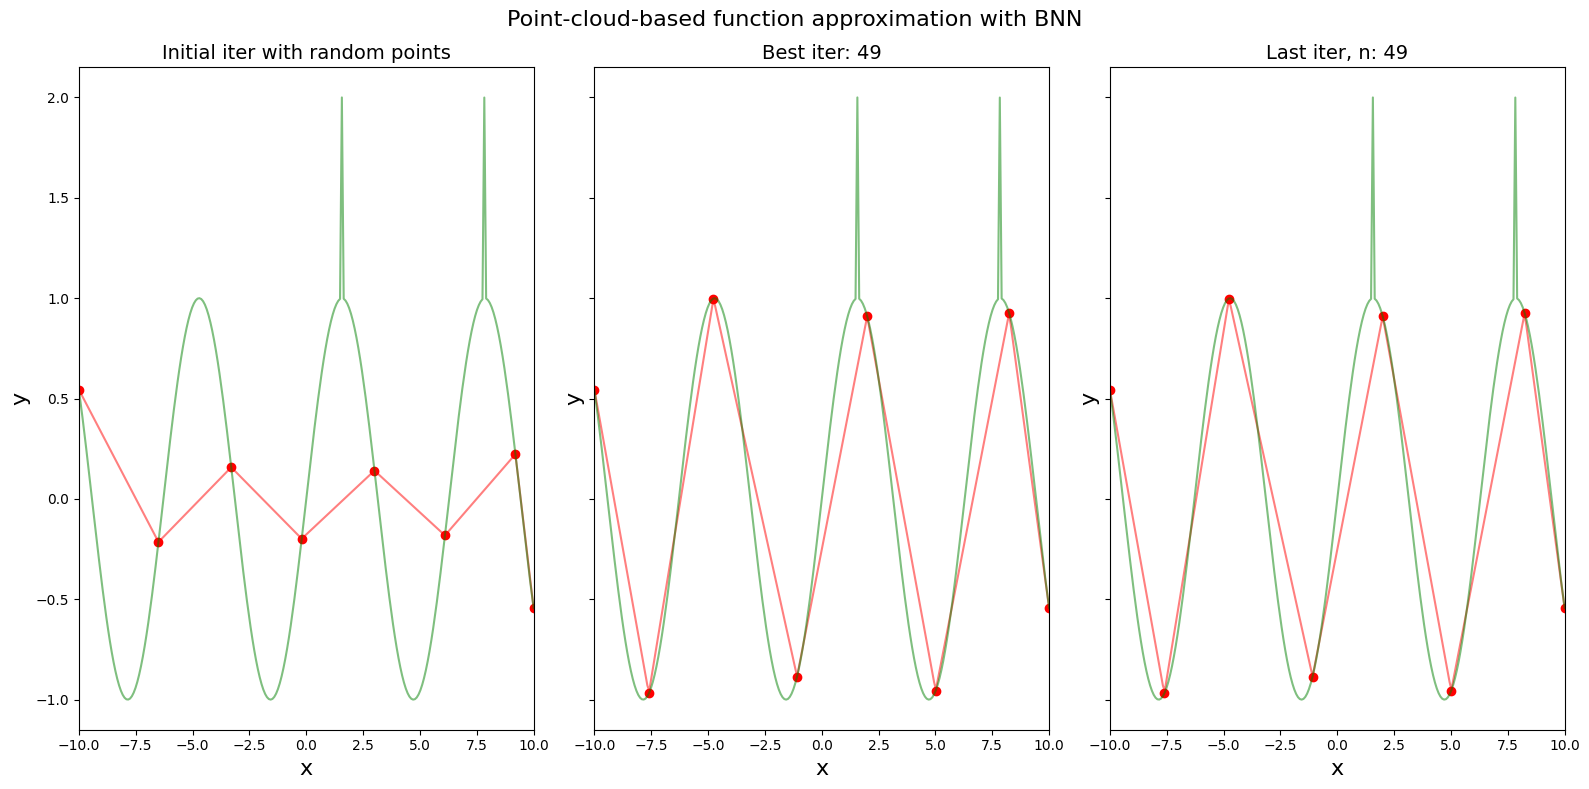

In [ ]:
def generate_training_data(func, domain, num_points, noise_std=0.0,
                           add_peak_outliers=False, outlier_magnitude=2.0, outlier_fraction=0.2,
                           random_seed=0):
    """
    Generate (x, y) samples from `func` on `domain` with optional Gaussian noise
    and optional outliers at local extrema (peaks/troughs).
    
    Parameters (English variable names and comments):
    - func: callable, function f(x)
    - domain: tuple (xmin, xmax)
    - num_points: int, number of points
    - noise_std: float, standard deviation of additive Gaussian noise
    - add_peak_outliers: bool, whether to modify some extrema to be outliers
    - outlier_magnitude: float, multiplier or additive factor for selected peaks
                        (explained below)
    - outlier_fraction: fraction (0..1) of detected extrema to turn into outliers
    - random_seed: int for reproducibility
    
    Returns:
    - x: numpy array shape (num_points,)
    - y: numpy array shape (num_points,)
    """
    rng = np.random.RandomState(random_seed)
    x = np.linspace(domain[0], domain[1], num_points)
    y = func(x) + np.random.normal(0, noise_std, size=x.shape)
    
    if add_peak_outliers:
        # Detect local extrema (simple discrete check)
        # interior indices 1..n-2
        extrema_mask = np.zeros_like(y, dtype=bool)
        for i in range(1, len(y)-1):
            if (y[i] > y[i-1] and y[i] > y[i+1]) or (y[i] < y[i-1] and y[i] < y[i+1]):
                extrema_mask[i] = True
        extrema_indices = np.where(extrema_mask)[0]
        
        if len(extrema_indices) > 0:
            k = max(1, int(np.ceil(len(extrema_indices) * outlier_fraction)))
            chosen = rng.choice(extrema_indices, size=k, replace=False)
            # Apply outlier modification: for clarity we add a signed offset proportional to outlier_magnitude
            for idx in chosen:
                # push peaks further away from zero: maintain sign but increase absolute value
                sign = np.sign(y[idx]) if y[idx] != 0 else 1.0
                y[idx] = y[idx] * outlier_magnitude + sign * 0.0  # multiplicative amplification
    return x, y

domain = [-10, 10]
num_points = 250
function = np.sin

# Without outliers
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points,
                                          noise_std=0, add_peak_outliers=True, random_seed=7)


np.random.seed(7)

plt.figure(figsize=(10,4))
plt.plot(x_train, y_train, label='train')
plt.title("Comparison: clean vs. peak-outlier-augmented sine samples")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)

dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
PERefFiltLim=length_weighted_persistent_entropy(dgmRefFilt)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 50 
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
alpha=0.3
for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = LengthWeightedPersistentEntropyLoss()
        entropyLoss = lossFunction(dgmRefFilt,dgmAprox)
        mseActual = mse_fn(y_train, y_aprox) 
        total_loss = mseActual + alpha * entropyLoss
        
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)
    
    
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    # print(total_loss)
    # print(entropyLoss)

    gradients = tape.gradient(total_loss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points


    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        

metricasLWPE_noise_badinit  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/Outlier_WithoutNoiseUnknownFunction_LWPERegularizer_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

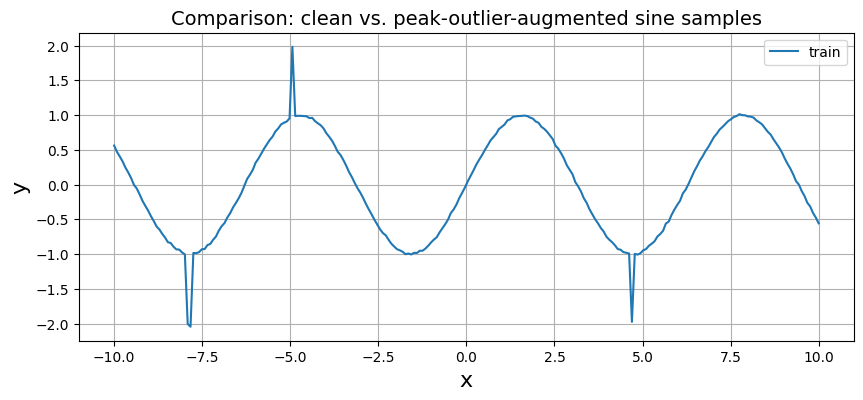

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


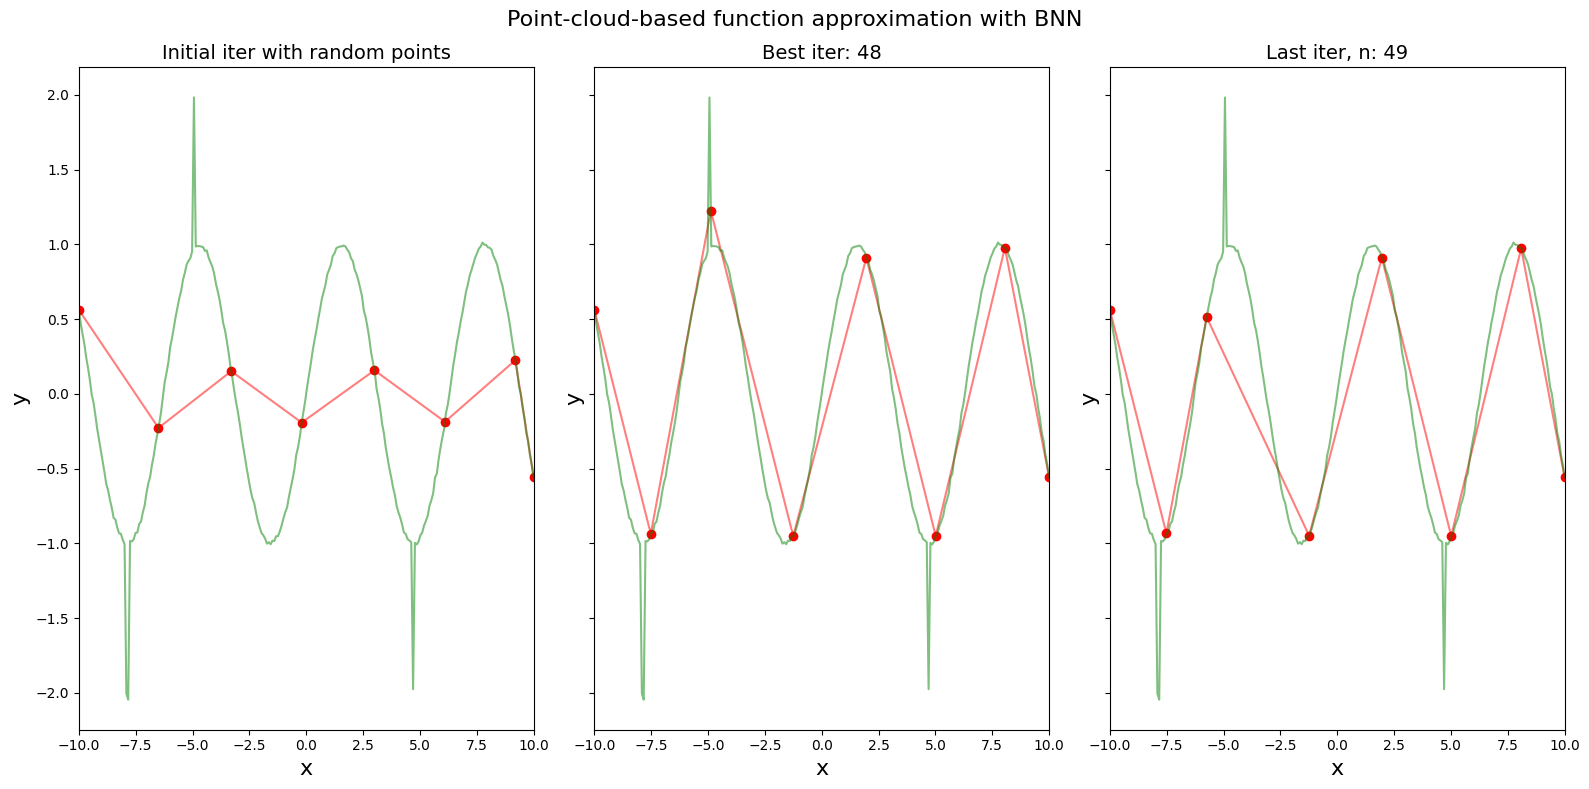

In [15]:
domain = [-10, 10]
num_points = 250
function = np.sin

# Without outliers
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points,
                                          noise_std=0.01, add_peak_outliers=True, random_seed=7)


np.random.seed(7)

plt.figure(figsize=(10,4))
plt.plot(x_train, y_train, label='train')
plt.title("Comparison: clean vs. peak-outlier-augmented sine samples")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)

dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
PERefFiltLim=length_weighted_persistent_entropy(dgmRefFilt)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 50 
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
alpha=0.3
for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = LengthWeightedPersistentEntropyLoss()
        entropyLoss = lossFunction(dgmRefFilt,dgmAprox)
        mseActual = mse_fn(y_train, y_aprox) 
        total_loss = mseActual + alpha * entropyLoss
        
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)
    
    
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    # print(total_loss)
    # print(entropyLoss)

    gradients = tape.gradient(total_loss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points


    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        

metricasLWPE_noise_badinit  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/Outlier_WithNoiseUnknownFunction_LWPERegularizer_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()